Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch: 1000 cost = 2.977328
Epoch: 2000 cost = 2.744027
Epoch: 3000 cost = 2.486630
Epoch: 4000 cost = 2.155865
Epoch: 5000 cost = 2.832572


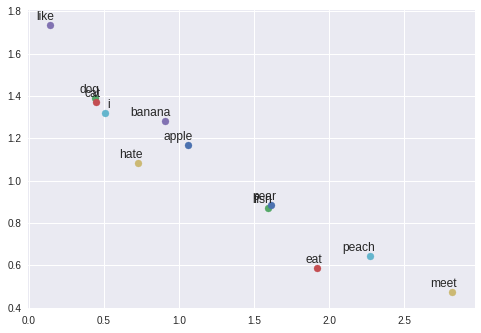

In [1]:
'''
  code by Minho Ryu @bzantium
  reference : https://github.com/golbin/TensorFlow-Tutorials/blob/master/04%20-%20Neural%20Network%20Basic/03%20-%20Word2Vec.py
'''
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

tf.reset_default_graph()

# 3 Words Sentence
sentences = [  "i eat meet",   "i eat fish",   "i like apple",   "i hate pear",   "i like banana",   "i hate peach",
             "dog eat meet", "dog eat fish", "dog like apple", "dog hate pear", "dog like banana", "dog hate peach",
             "cat eat meet", "cat eat fish", "cat like apple", "cat hate pear", "cat like banana", "cat hate peach"]

word_sequence = " ".join(sentences).split()
word_list = " ".join(sentences).split()
word_list = list(set(word_list))
word_dict = {w: i for i, w in enumerate(word_list)}

# Word2Vec Parameter
batch_size = 20
embedding_size = 2 # To show 2 dim embedding graph
num_sampled = 5 # for negative sampling, less than batch_size
vocab_size = len(word_list)

def random_batch(data, size):
    random_inputs = []
    random_labels = []
    random_index = np.random.choice(range(len(data)), size, replace=False)

    for i in random_index:
        random_inputs.append(data[i][0])  # target
        random_labels.append([data[i][1]])  # context word

    return random_inputs, random_labels

# Make skip gram of one size window
skip_grams = []
for i in range(1, len(word_sequence) - 1):
    target = word_dict[word_sequence[i]]
    context = [word_dict[word_sequence[i - 1]], word_dict[word_sequence[i + 1]]]

    for w in context:
        skip_grams.append([target, w])

# Model
class SGNS(object):
    def __init__(self, sess, batch_size, vocab_size, embedding_size, num_sampled):
        self.sess = sess
        self.batch_size = batch_size
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.num_sampled = num_sampled
        self._build_model()
        
    def _build_model(self):
        self.inputs = tf.placeholder(tf.int32, shape=[self.batch_size])
        self.labels = tf.placeholder(tf.int32, shape=[self.batch_size, 1]) # To use tf.nn.nce_loss, [batch_size, 1]

        self.embeddings = tf.Variable(tf.random_uniform([self.vocab_size, self.embedding_size], -1.0, 1.0))
        self.selected_embed = tf.nn.embedding_lookup(self.embeddings, self.inputs)

        self.nce_weights = tf.Variable(tf.random_uniform([self.vocab_size, self.embedding_size], -1.0, 1.0))
        self.nce_biases = tf.Variable(tf.zeros([self.vocab_size]))
        
        self.cost = tf.reduce_mean(tf.nn.nce_loss(self.nce_weights, self.nce_biases, self.labels, self.selected_embed, self.num_sampled, self.vocab_size))
        self.optimizer = tf.train.AdamOptimizer(0.001).minimize(self.cost)
        
        tf.global_variables_initializer().run()
    
    def train(self, inputs, labels):
        return self.sess.run([self.cost, self.optimizer], feed_dict={self.inputs: inputs, self.labels: labels})
      
# Training
run_config = tf.ConfigProto()
run_config.gpu_options.allow_growth=True
with tf.Session(config=run_config) as sess:
    model = SGNS(sess, batch_size, vocab_size, embedding_size, num_sampled)
    for epoch in range(5000):
        batch_inputs, batch_labels = random_batch(skip_grams, batch_size)
        loss, _ = model.train(batch_inputs, batch_labels)

        if (epoch + 1) % 1000 == 0:
            print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))

    trained_embeddings = model.embeddings.eval()

for i, label in enumerate(word_list):
    x, y = trained_embeddings[i]
    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
plt.show()